In [50]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
% matplotlib inline
pd.set_option('display.max_colwidth', 200)

In [51]:
def read_text(filename):
    file = open(filename, mode='rt', encoding='utf-8')
    text = file.read()
    file.close()
    return text

In [52]:
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

In [53]:
data = read_text("/content/fra.txt")
fra_eng = to_lines(data)
fra_eng = array(fra_eng)

In [54]:
fra_eng = fra_eng[:50000,:]

In [55]:
fra_eng

array([['Va !', 'Go.'],
       ['Marche.', 'Go.'],
       ['Bouge !', 'Go.'],
       ...,
       ["Tom a aimé ce qu'il a vu.", 'Tom liked what he saw.'],
       ["Tom aima ce qu'il vit.", 'Tom liked what he saw.'],
       ['Tom aussi aime skier.', 'Tom likes skiing, too.']], dtype='<U325')

In [56]:
fra_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in fra_eng[:,0]]
fra_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in fra_eng[:,1]]

In [57]:
fra_eng

array([['Va ', 'Go'],
       ['Marche', 'Go'],
       ['Bouge ', 'Go'],
       ...,
       ['Tom a aimé ce quil a vu', 'Tom liked what he saw'],
       ['Tom aima ce quil vit', 'Tom liked what he saw'],
       ['Tom aussi aime skier', 'Tom likes skiing too']], dtype='<U325')

In [58]:
for i in range(len(fra_eng)):
    fra_eng[i,0] = fra_eng[i,0].lower()
    
    fra_eng[i,1] = fra_eng[i,1].lower()

In [59]:
fra_eng

array([['va ', 'go'],
       ['marche', 'go'],
       ['bouge ', 'go'],
       ...,
       ['tom a aimé ce quil a vu', 'tom liked what he saw'],
       ['tom aima ce quil vit', 'tom liked what he saw'],
       ['tom aussi aime skier', 'tom likes skiing too']], dtype='<U325')

In [60]:
eng_l = []
fra_l = []

for i in fra_eng[:,1]:
    eng_l.append(len(i.split()))

for i in fra_eng[:,0]:
    fra_l.append(len(i.split()))

In [61]:
length_df = pd.DataFrame({'eng':eng_l, 'fra':fra_l})

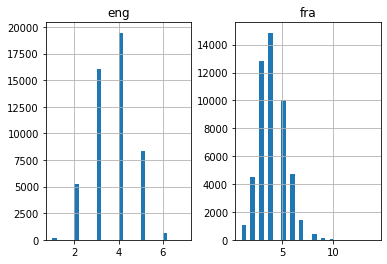

In [62]:
length_df.hist(bins = 30)
plt.show()

In [63]:
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [64]:
eng_tokenizer = tokenization(fra_eng[:, 1])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 6042


In [65]:
fra_tokenizer = tokenization(fra_eng[:, 0])
fra_vocab_size = len(fra_tokenizer.word_index) + 1

fra_length = 8
print('French Vocabulary Size: %d' % fra_vocab_size)

French Vocabulary Size: 13974


In [66]:
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

In [67]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(fra_eng, test_size=0.2, random_state = 12)

In [68]:
trainX = encode_sequences(fra_tokenizer, fra_length, train[:, 0])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 1])

In [69]:
testX = encode_sequences(fra_tokenizer, fra_length, test[:, 0])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 1])

In [70]:
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [71]:
model = build_model(fra_vocab_size, eng_vocab_size, fra_length, eng_length, 512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [72]:
filename = 'model.h1.152'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=30, batch_size=512, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

Epoch 1/30
63/63 [==============================] - 253s 4s/step - loss: 4.3848 - val_loss: 2.9494

Epoch 00001: val_loss improved from inf to 2.94936, saving model to model.h1.152


INFO:tensorflow:Assets written to: model.h1.152/assets


INFO:tensorflow:Assets written to: model.h1.152/assets


Epoch 2/30
63/63 [==============================] - 245s 4s/step - loss: 2.8004 - val_loss: 2.7872

Epoch 00002: val_loss improved from 2.94936 to 2.78716, saving model to model.h1.152


INFO:tensorflow:Assets written to: model.h1.152/assets


INFO:tensorflow:Assets written to: model.h1.152/assets


Epoch 3/30
63/63 [==============================] - 245s 4s/step - loss: 2.6564 - val_loss: 2.5903

Epoch 00003: val_loss improved from 2.78716 to 2.59027, saving model to model.h1.152


INFO:tensorflow:Assets written to: model.h1.152/assets


INFO:tensorflow:Assets written to: model.h1.152/assets


Epoch 4/30
63/63 [==============================] - 244s 4s/step - loss: 2.4527 - val_loss: 2.4156

Epoch 00004: val_loss improved from 2.59027 to 2.41564, saving model to model.h1.152


INFO:tensorflow:Assets written to: model.h1.152/assets


INFO:tensorflow:Assets written to: model.h1.152/assets


Epoch 5/30
63/63 [==============================] - 245s 4s/step - loss: 2.2838 - val_loss: 2.3105

Epoch 00005: val_loss improved from 2.41564 to 2.31049, saving model to model.h1.152


INFO:tensorflow:Assets written to: model.h1.152/assets


INFO:tensorflow:Assets written to: model.h1.152/assets


Epoch 6/30
63/63 [==============================] - 247s 4s/step - loss: 2.1547 - val_loss: 2.2491

Epoch 00006: val_loss improved from 2.31049 to 2.24908, saving model to model.h1.152


INFO:tensorflow:Assets written to: model.h1.152/assets


INFO:tensorflow:Assets written to: model.h1.152/assets


Epoch 7/30
63/63 [==============================] - 245s 4s/step - loss: 2.0335 - val_loss: 2.1484

Epoch 00007: val_loss improved from 2.24908 to 2.14840, saving model to model.h1.152


INFO:tensorflow:Assets written to: model.h1.152/assets


INFO:tensorflow:Assets written to: model.h1.152/assets


Epoch 8/30
63/63 [==============================] - 244s 4s/step - loss: 1.9152 - val_loss: 2.0649

Epoch 00008: val_loss improved from 2.14840 to 2.06486, saving model to model.h1.152


INFO:tensorflow:Assets written to: model.h1.152/assets


INFO:tensorflow:Assets written to: model.h1.152/assets


Epoch 9/30
63/63 [==============================] - 244s 4s/step - loss: 1.8012 - val_loss: 1.9913

Epoch 00009: val_loss improved from 2.06486 to 1.99129, saving model to model.h1.152


INFO:tensorflow:Assets written to: model.h1.152/assets


INFO:tensorflow:Assets written to: model.h1.152/assets


Epoch 10/30
63/63 [==============================] - 244s 4s/step - loss: 1.7081 - val_loss: 1.9438

Epoch 00010: val_loss improved from 1.99129 to 1.94379, saving model to model.h1.152


INFO:tensorflow:Assets written to: model.h1.152/assets


INFO:tensorflow:Assets written to: model.h1.152/assets


Epoch 11/30
63/63 [==============================] - 245s 4s/step - loss: 1.6164 - val_loss: 1.8871

Epoch 00011: val_loss improved from 1.94379 to 1.88710, saving model to model.h1.152


INFO:tensorflow:Assets written to: model.h1.152/assets


INFO:tensorflow:Assets written to: model.h1.152/assets


Epoch 12/30
63/63 [==============================] - 244s 4s/step - loss: 1.5346 - val_loss: 1.8402

Epoch 00012: val_loss improved from 1.88710 to 1.84019, saving model to model.h1.152


INFO:tensorflow:Assets written to: model.h1.152/assets


INFO:tensorflow:Assets written to: model.h1.152/assets


Epoch 13/30
63/63 [==============================] - 244s 4s/step - loss: 1.4400 - val_loss: 1.7841

Epoch 00013: val_loss improved from 1.84019 to 1.78414, saving model to model.h1.152


INFO:tensorflow:Assets written to: model.h1.152/assets


INFO:tensorflow:Assets written to: model.h1.152/assets


Epoch 14/30
63/63 [==============================] - 244s 4s/step - loss: 1.3686 - val_loss: 1.7473

Epoch 00014: val_loss improved from 1.78414 to 1.74734, saving model to model.h1.152


INFO:tensorflow:Assets written to: model.h1.152/assets


INFO:tensorflow:Assets written to: model.h1.152/assets


Epoch 15/30
63/63 [==============================] - 244s 4s/step - loss: 1.2910 - val_loss: 1.7054

Epoch 00015: val_loss improved from 1.74734 to 1.70541, saving model to model.h1.152


INFO:tensorflow:Assets written to: model.h1.152/assets


INFO:tensorflow:Assets written to: model.h1.152/assets


Epoch 16/30
63/63 [==============================] - 246s 4s/step - loss: 1.2111 - val_loss: 1.6681

Epoch 00016: val_loss improved from 1.70541 to 1.66812, saving model to model.h1.152


INFO:tensorflow:Assets written to: model.h1.152/assets


INFO:tensorflow:Assets written to: model.h1.152/assets


Epoch 17/30
63/63 [==============================] - 247s 4s/step - loss: 1.1387 - val_loss: 1.6283

Epoch 00017: val_loss improved from 1.66812 to 1.62832, saving model to model.h1.152


INFO:tensorflow:Assets written to: model.h1.152/assets


INFO:tensorflow:Assets written to: model.h1.152/assets


Epoch 18/30
63/63 [==============================] - 249s 4s/step - loss: 1.0682 - val_loss: 1.6154

Epoch 00018: val_loss improved from 1.62832 to 1.61538, saving model to model.h1.152


INFO:tensorflow:Assets written to: model.h1.152/assets


INFO:tensorflow:Assets written to: model.h1.152/assets


Epoch 19/30
63/63 [==============================] - 247s 4s/step - loss: 1.0044 - val_loss: 1.5682

Epoch 00019: val_loss improved from 1.61538 to 1.56820, saving model to model.h1.152


INFO:tensorflow:Assets written to: model.h1.152/assets


INFO:tensorflow:Assets written to: model.h1.152/assets


Epoch 20/30
63/63 [==============================] - 247s 4s/step - loss: 0.9375 - val_loss: 1.5537

Epoch 00020: val_loss improved from 1.56820 to 1.55365, saving model to model.h1.152


INFO:tensorflow:Assets written to: model.h1.152/assets


INFO:tensorflow:Assets written to: model.h1.152/assets


Epoch 21/30
63/63 [==============================] - 247s 4s/step - loss: 0.8743 - val_loss: 1.5251

Epoch 00021: val_loss improved from 1.55365 to 1.52506, saving model to model.h1.152


INFO:tensorflow:Assets written to: model.h1.152/assets


INFO:tensorflow:Assets written to: model.h1.152/assets


Epoch 22/30
63/63 [==============================] - 245s 4s/step - loss: 0.8212 - val_loss: 1.5064

Epoch 00022: val_loss improved from 1.52506 to 1.50641, saving model to model.h1.152


INFO:tensorflow:Assets written to: model.h1.152/assets


INFO:tensorflow:Assets written to: model.h1.152/assets


Epoch 23/30
63/63 [==============================] - 245s 4s/step - loss: 0.7523 - val_loss: 1.4904

Epoch 00023: val_loss improved from 1.50641 to 1.49043, saving model to model.h1.152


INFO:tensorflow:Assets written to: model.h1.152/assets


INFO:tensorflow:Assets written to: model.h1.152/assets


Epoch 24/30
63/63 [==============================] - 245s 4s/step - loss: 0.7074 - val_loss: 1.4845

Epoch 00024: val_loss improved from 1.49043 to 1.48449, saving model to model.h1.152


INFO:tensorflow:Assets written to: model.h1.152/assets


INFO:tensorflow:Assets written to: model.h1.152/assets


Epoch 25/30
63/63 [==============================] - 251s 4s/step - loss: 0.6548 - val_loss: 1.4746

Epoch 00025: val_loss improved from 1.48449 to 1.47464, saving model to model.h1.152


INFO:tensorflow:Assets written to: model.h1.152/assets


INFO:tensorflow:Assets written to: model.h1.152/assets


Epoch 26/30
63/63 [==============================] - 247s 4s/step - loss: 0.6007 - val_loss: 1.4550

Epoch 00026: val_loss improved from 1.47464 to 1.45497, saving model to model.h1.152


INFO:tensorflow:Assets written to: model.h1.152/assets


INFO:tensorflow:Assets written to: model.h1.152/assets


Epoch 27/30
63/63 [==============================] - 248s 4s/step - loss: 0.5660 - val_loss: 1.4445

Epoch 00027: val_loss improved from 1.45497 to 1.44454, saving model to model.h1.152


INFO:tensorflow:Assets written to: model.h1.152/assets


INFO:tensorflow:Assets written to: model.h1.152/assets


Epoch 28/30
63/63 [==============================] - 248s 4s/step - loss: 0.5199 - val_loss: 1.4313

Epoch 00028: val_loss improved from 1.44454 to 1.43135, saving model to model.h1.152


INFO:tensorflow:Assets written to: model.h1.152/assets


INFO:tensorflow:Assets written to: model.h1.152/assets


Epoch 29/30
63/63 [==============================] - 248s 4s/step - loss: 0.4768 - val_loss: 1.4281

Epoch 00029: val_loss improved from 1.43135 to 1.42810, saving model to model.h1.152


INFO:tensorflow:Assets written to: model.h1.152/assets


INFO:tensorflow:Assets written to: model.h1.152/assets


Epoch 30/30
63/63 [==============================] - 249s 4s/step - loss: 0.4378 - val_loss: 1.4224

Epoch 00030: val_loss improved from 1.42810 to 1.42245, saving model to model.h1.152


INFO:tensorflow:Assets written to: model.h1.152/assets


INFO:tensorflow:Assets written to: model.h1.152/assets


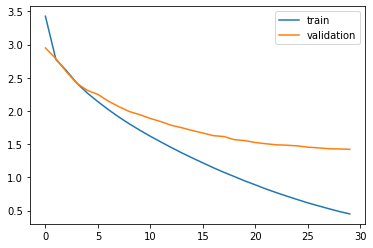

In [73]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [74]:
model = load_model('model.h1.152')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [75]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [76]:
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [77]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [78]:
pd.set_option('display.max_colwidth', 200)

In [79]:
pred_df.head(25)

,actual,predicted
0,je suis contente de lentendre,im glad to it
1,cest mort,its bored
2,ne tarrête pas de grimper,keep
3,je vous respecte,i see these
4,quest ce que tu as fait ensuite,what did i say
5,je vous donnerai un indice,ill make you a towel
6,sontelles déjà arrivées,are they arrived yet
7,elle sait tout,she knows know
8,jespère que cest vrai,i hope its true
9,ils mont dépouillée,they robbed me blind


In [80]:
pred_df.tail(25)

,actual,predicted
9975,il nous faut largent,we need to
9976,fais comme tu veux,do as you
9977,je vous lai dit,i told you why
9978,les serpents sont des reptiles,men are
9979,je nai pas peur dessayer,im not afraid a death
9980,je fus très flattée,i was very
9981,emmenezle à létage,get upstairs
9982,rappellemoi de suite,help me back
9983,tom vit dans une grotte,tom was to a
9984,jaime la choucroute,i like mathematics


In [81]:
pred_df.tail(25)

,actual,predicted
9975,il nous faut largent,we need to
9976,fais comme tu veux,do as you
9977,je vous lai dit,i told you why
9978,les serpents sont des reptiles,men are
9979,je nai pas peur dessayer,im not afraid a death
9980,je fus très flattée,i was very
9981,emmenezle à létage,get upstairs
9982,rappellemoi de suite,help me back
9983,tom vit dans une grotte,tom was to a
9984,jaime la choucroute,i like mathematics


In [82]:
pred_df.sample(25)

,actual,predicted
5516,la connaissezvous,do you know him
1609,donnemoi cinq jours,give me five my days
2319,jaimerais plutôt pas,id like to not abroad
8130,la fête est lundi,the partys is monday
565,cest mon garçon,this is my dog
919,à quelle heure est le dîner,whats an is
4504,tom a une bonne guitare,tom has a good
4390,elles sont bonnes toutes les deux,they both
9311,tu as été sélectionnée,you were warned
4135,par ici sil vous plait,turn please
